# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

#### Edición 2024

---


## Trabajo práctico entregable - Parte 2

### Integrantes

- Fernando Camino
- Emanuel Nicolás Herrador
- Juana Rapoport
- Sebastián Stutz
- Juan Ignacio Szurlewicz

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import statsmodels as sm
import statsmodels.api as sma

sns.set_context('talk')

### Lectura del dataset

Leemos nuestro dataset con las respuestas a la encuesta realizada por SysArmy en 2023, en Argentina.

In [2]:
file_url ='https://raw.githubusercontent.com/DiploDatos/AnalisisyVisualizacion/master/sysarmy_survey_2023_processed.csv'
df = pd.read_csv(file_url)

# Mostramos el head para ver si se hizo bien la lectura
df.head()

,work_country,work_province,work_dedication,work_contract_type,salary_monthly_BRUTO,salary_monthly_NETO,salary_in_usd,salary_last_dollar_value,salary_has_bonus,salary_bonus_tied_to,...,profile_studies_level_state,profile_career,Institución educativa,¿Salir o seguir contestando sobre las guardias?,work_on_call_duty,salary_on_call_duty_charge,Aclará el número que ingresaste en el campo anterior,¿Salir o seguir contestando sobre estudios?,profile_age,profile_gender
0,Argentina,Catamarca,Full-Time,Staff (planta permanente),680000.0,520000.0,NaN,NaN,No,No recibo bono,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,Varón Cis
1,Argentina,Catamarca,Full-Time,Staff (planta permanente),650000.0,520000.0,NaN,NaN,No,No recibo bono,...,Completo,Licenciatura en Sistemas de Información,Universidad Siglo 21,Terminar encuesta,NaN,NaN,NaN,NaN,45,Varón Cis
2,Argentina,Catamarca,Full-Time,Staff (planta permanente),125000.0,104000.0,NaN,NaN,No,No recibo bono,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,Mujer Cis
3,Argentina,Chaco,Part-Time,Staff (planta permanente),190000.0,240000.0,NaN,NaN,No,No recibo bono,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,Mujer Cis
4,Argentina,Chaco,Full-Time,Tercerizado (trabajo a través de consultora o ...,250000.0,207000.0,NaN,NaN,No,No recibo bono,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,Varón Cis


### Utilidades

Vamos a considerar las siguientes funciones y variables que nos van a ser útiles a lo largo de todo el proyecto, tanto para graficar como para tomar decisiones.

In [3]:
# Gráfico: Eje X y/o Y con K para miles
def k_formatter(g, max_value, tick_diff = 200_000):
    """
    Función para formatear los ticks del eje X en miles
    """
    g.set_xticks(np.arange(0, max_value + tick_diff, tick_diff))
    x_labels = ['{:,.0f}'.format(x) + 'K' for x in g.get_xticks()/1000]
    g.set_xticklabels(x_labels)

# ¿Rechazamos la H0?
def hypothesis_test(p_value, alpha):
    """
    Función para evaluar si rechazamos la hipótesis nula
    """
    if p_value < alpha:
        print(f"Rechazamos la hipótesis nula con un p-valor de {p_value}")
        return True
    else:
        print(f"No rechazamos la hipótesis nula con un p-valor de {p_value}")
        return False

# Variables globales para los gráficos
PALETTE = 'hls'

### Transformación y limpieza del dataset

Para la realización de los siguientes puntos, consideramos importante realizar una limpieza y la transformación correspondiente a nuestros datos.

Para ello, como queremos trabajar con las columnas del salario y del género, vamos a considerar lo siguiente:

- Vamos a quedarnos con aquellas filas que no tengan valor nulo en las columnas `salary_monthly_NETO` y `profile_gender`.
- Vamos a unificar los valores de la columna `profile_gender` en tres posibilidades: `Mujer`, `Varón` y `Diversidad` para poder trabajar con ellas.
- Vamos a considerar un mínimo de $\$73.029,21$ para el salario neto, dado que este límite se obtiene aplicando las [retenciones al sueldo por ley](https://www.argentina.gob.ar/trabajo/buscastrabajo/conocetusderechos/salario#aportes) ($17\%$) al [Salario Mínimo Vital y Móvil](https://www.argentina.gob.ar/noticias/incremento-del-salario-minimo-vital-y-movil) en Argentina a mediados del 2023 ($\$87.987$)
- Vamos a considerar, una vez hechos todos estos filtros, el $95\%$ de los datos con menor salario neto para evitar los casos extremos superiores (casos excepcionales como el de 45M por ejemplo).

In [4]:
# VARIABLES GLOBALES

## - Columnas importantes a considerar
IMPORTANT_COLUMNS = ['salary_monthly_NETO', 'profile_gender']

## - Salario Mínimo Vital y Móvil a mediados del 2023
SMVYM = 87_987

## - Porcentaje de aportes obligatorios en Argentina
SALARY_CONTRIBUTIONS = 0.17

## - Percentil a considerar para salarios netos altos
PERCENTILE = 0.95

Dado esto, realizamos la limpieza mencionada y obtenemos el dataset con el que vamos a trabajar.

In [5]:
def print_rows_erased(df, df_cleaned):
    """
    Imprime la cantidad de filas eliminadas
    """
    print(f"Se eliminaron {df.shape[0] - df_cleaned.shape[0]} filas")

def clean_nan_values(df):
    """
    Limpia los valores nulos en las columnas importantes
    """
    df_r = df.dropna(subset=IMPORTANT_COLUMNS)
    print_rows_erased(df, df_r)
    return df_r

def filter_small_salaries(df):
    """
    Filtra los salarios netos menores al Salario Mínimo Vital y Móvil con los aportes
    """
    df_r = df[df['salary_monthly_NETO'] > SMVYM * (1 - SALARY_CONTRIBUTIONS)]
    print_rows_erased(df, df_r)
    return df_r

def filter_outliers(df):
    """
    Filtra los salarios netos altos
    """
    df_r = df[df['salary_monthly_NETO'] < df['salary_monthly_NETO'].quantile(PERCENTILE)]
    print_rows_erased(df, df_r)
    return df_r

def uniform_gender_values(df):
    """
    Unifica los valores de género en el dataset.
    A los que no matcheen se les pone 'Otro'
    """
    dict_transformation = {
        'Varón Cis': 'Varón',
        'Hombre': 'Varón',
        'Mujer': 'Mujer',
        'Mujer Cis': 'Mujer',
        'Femenino': 'Mujer',
        'mujer': 'Mujer',
        'Mujer':'Mujer',
        'Queer':'Diversidades',
        'Varón Trans':'Diversidades',
        'No binarie':'Diversidades',
        'Mujer Trans':'Diversidades',
        'Fluido':'Diversidades',
        'Bigénero':'Diversidades',
        'Gay':'Diversidades'
        }

    df_r = df.copy()
    df_r['gender'] = df['profile_gender'].map(dict_transformation).fillna('Otro')
    return df_r

# Hago la limpieza
df2 = clean_nan_values(df)
df2 = filter_small_salaries(df2)
df2 = filter_outliers(df2)
df2 = uniform_gender_values(df2)

# Muestro datos de las columnas para ver si se hizo bien la limpieza
print("\nCOLUMNA DE SALARIO:\n", df2['salary_monthly_NETO'].describe().apply(lambda x: format(x, '.2f')))

print("\nCOLUMNA DE GÉNERO:\n", df2['gender'].value_counts())

Se eliminaron 239 filas
Se eliminaron 367 filas
Se eliminaron 262 filas

COLUMNA DE SALARIO:
 count       4937.00
mean      471552.04
std       288507.67
min        73560.00
25%       276000.00
50%       410000.00
75%       570847.00
max      1749059.00
Name: salary_monthly_NETO, dtype: object

COLUMNA DE GÉNERO:
 gender
Varón           3614
Mujer            871
Otro             373
Diversidades      79
Name: count, dtype: int64


Hecha toda esta limpieza (la cual se pudo hacer dados los análisis vistos en el primer entregable), podemos notar que el dataset resultante tiene una distribución de salarios más acotada y con menos valores extremos que el inicial.

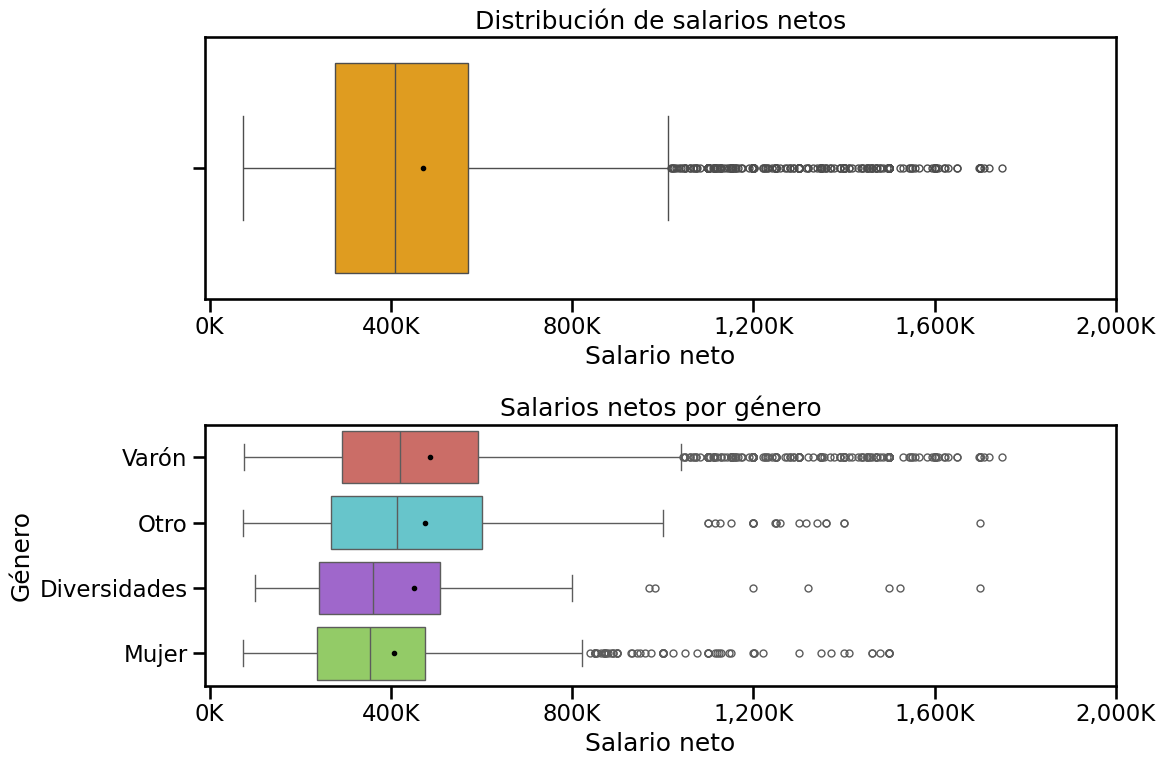

In [6]:
# GRÁFICO: Vemos la distribución de los salarios netos por género con el BOXPLOT
# También se hace el mismo gráfico pero para ver la totalidad de los datos

df2_median_order = \
    df2.groupby('gender')['salary_monthly_NETO'].median().sort_values(ascending=False).index

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 8))

# Total
g_total = sns.boxplot(x = 'salary_monthly_NETO', data = df2, ax = ax[0], color = 'orange', fliersize = 5, \
    showmeans = True, meanprops = {'marker': '.', 'markerfacecolor': 'black', 'markeredgecolor': 'black'})

ax[0].set_title('Distribución de salarios netos')
ax[0].set_xlabel('Salario neto')

k_formatter(g = g_total, max_value = df2['salary_monthly_NETO'].max(), tick_diff = 400_000)

# Por género

g_gender = sns.boxplot(x = 'salary_monthly_NETO', y = 'gender', data = df2, ax = ax[1], \
    order = df2_median_order, fliersize = 5, palette = PALETTE, hue = 'gender', \
    showmeans = True, meanprops = {'marker': '.', 'markerfacecolor': 'black', 'markeredgecolor': 'black'})

ax[1].set_title('Salarios netos por género')
ax[1].set_xlabel('Salario neto')
ax[1].set_ylabel('Género')

k_formatter(g = g_gender, max_value = df2['salary_monthly_NETO'].max(), tick_diff = 400_000)

plt.tight_layout()
plt.show()

Asimismo, para los siguientes puntos vamos a considerar estas variables para realizar los análisis correspondientes (solo tomaremos en cuenta las respuestas que consideramos de *Varón* y *Mujer*).

In [7]:
# ALPHA (α) = 0.05
ALPHA = 0.05

# Grupos de salario por género (Hombre y Mujer)
salary_man = df2[df2['gender'] == 'Varón']['salary_monthly_NETO']
salary_woman = df2[df2['gender'] == 'Mujer']['salary_monthly_NETO']

# Chequeamos con las cantidades para ver si se hizo bien la división
print("\nCANTIDAD DE HOMBRES:", salary_man.shape[0])
print("CANTIDAD DE MUJERES:", salary_woman.shape[0])


CANTIDAD DE HOMBRES: 3614
CANTIDAD DE MUJERES: 871


### Ejercicio 1: Estimación

#### Consigna

Calcular una estimación puntual y un intervalo de confianza de nivel ($1-\alpha$) para la resta entre la *media* del salario neto para hombres menos la media del salario neto para mujeres (diferencia de las medias entre los dos grupos).

¿Cómo se relaciona este intervalo de confianza con el test de hipótesis?

#### Resolución

##### Estimación puntual

Para hacer una estimación puntual de la diferencia de las medias entre los salarios netos de los hombres y de las mujeres, vamos a considerar los siguientes estadísticos para cada subpoblación:

$$\hat{\theta}_M = \bar{X_M}$$
$$\hat{\theta}_W = \bar{X_W}$$
$$\hat{\theta} = |\hat{\theta}_M - \hat{\theta}_W|$$

donde M representa a los hombres y W a las mujeres, y donde $\bar{X} = \frac{1}{n}\sum_{i=1}^n x_i$ es la media muestral.

Por ello mismo, tenemos que:

In [8]:
# Calcular los estimadores puntuales
def calculate_estimators(data):
    """
    Calcula los estimadores puntuales de la distribución
    """
    return {
        'mean': data.mean(),
        'std': data.std(),
        'variance': data.std()**2,
        'size': data.size
    }

def show_estimators(name, estimator):
    """
    Muestra los estimadores puntuales
    """
    print(f"\nPara {name} tenemos los siguientes estimadores:")
    print(f"    Media: {estimator['mean']:.2f}")
    print(f"    Desviación estándar: {estimator['std']:.2f}")
    print(f"    Varianza: {estimator['variance']:.2f}")
    print(f"    Tamaño de la muestra: {estimator['size']}")

# Calculamos los estimadores
salary_man_estimators = calculate_estimators(data = salary_man)
salary_woman_estimators = calculate_estimators(data = salary_woman)

# Calculamos la diferencia entre las medias
salary_mean_diff = abs(salary_man_estimators['mean'] - salary_woman_estimators['mean'])

# Mostramos los estimadores y la diferencia
show_estimators(name = 'Hombres', estimator = salary_man_estimators)
show_estimators(name = 'Mujeres', estimator = salary_woman_estimators)

print(f"\nTeniendo, entonces, una diferencia de {salary_mean_diff:.2f} entre las medias")
print(f"\nEsto implica que el ESTIMADOR PUNTUAL de la DIFERENCIA ENTRE LAS MEDIAS de las dos \
subpoblaciones es de ${salary_mean_diff:.2f} ($ARS)")


Para Hombres tenemos los siguientes estimadores:
    Media: 487332.12
    Desviación estándar: 294202.96
    Varianza: 86555380329.75
    Tamaño de la muestra: 3614

Para Mujeres tenemos los siguientes estimadores:
    Media: 406211.83
    Desviación estándar: 252559.19
    Varianza: 63786143506.38
    Tamaño de la muestra: 871

Teniendo, entonces, una diferencia de 81120.30 entre las medias

Esto implica que el ESTIMADOR PUNTUAL de la DIFERENCIA ENTRE LAS MEDIAS de las dos subpoblaciones es de $81120.30 ($ARS)


Nosotros podemos ver esta diferencia gráficamente:

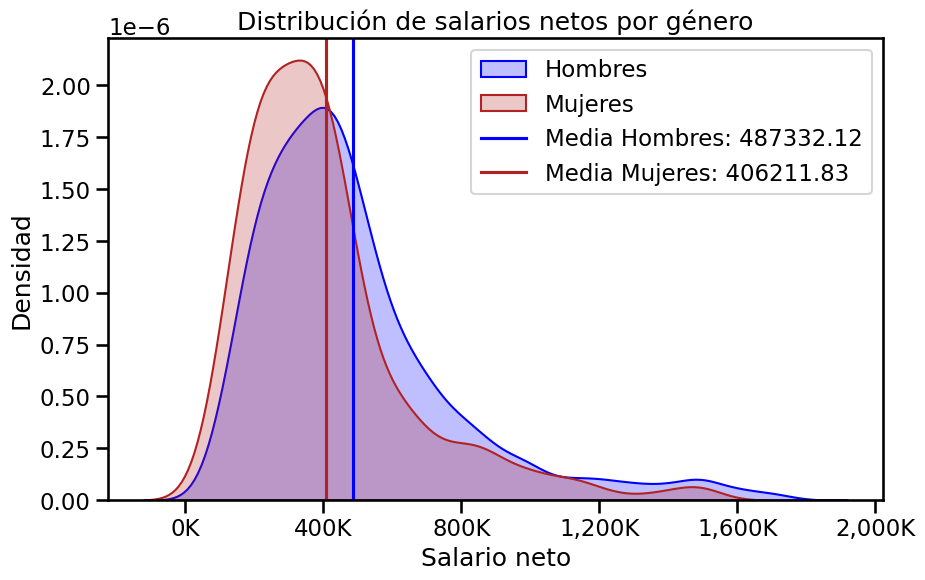

In [9]:
# GRÁFICO: Vemos las distribuciones de salario para hombres y mujeres, marcando sus medias para notar la diferencia existente en la muestra

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 6))

g = sns.kdeplot(data = salary_man, fill = True, color = 'blue', label = 'Hombres')
g2 = sns.kdeplot(data = salary_woman, fill = True, color = 'firebrick', label = 'Mujeres')

ax.axvline(x = salary_man.mean(), color = 'blue', label = f"Media Hombres: {salary_man_estimators['mean'].round(2)}")
ax.axvline(x = salary_woman.mean(), color = 'firebrick', label = f"Media Mujeres: {salary_woman_estimators['mean'].round(2)}")

k_formatter(g = g2, max_value = df2['salary_monthly_NETO'].max(), tick_diff = 400_000)

ax.set_title('Distribución de salarios netos por género')
ax.set_xlabel('Salario neto')
ax.set_ylabel('Densidad')

plt.legend()
plt.show()

##### Intervalo de confianza

Para este punto, queremos calcular un intervalo de confianza del $95\%$ para la diferencia entre las medias de los salarios netos de los hombres y de las mujeres.

Para ello, sabemos que las posibilidades a considerar para realizar nuestra estimación son:
1. Las dos subpoblaciones tienen distribución normal e igual tamaño
2. Las dos subpoblaciones tienen distribución normal y distinto tamaño
   1. Varianzas iguales
   2. Varianzas distintas
   
Por esto mismo, nos fijemos qué es lo que pasa en nuestro caso con nuestras subpoblaciones, calculando los estimadores correspondientes y/o haciendo los tests de hipótesis en las muestras correspondientes.

Por esto, entonces, nos fijemos primero si las subpoblaciones tienen distribución normal. Veamos nuevamente el gráfico de densidad de los salarios netos de hombres y mujeres:

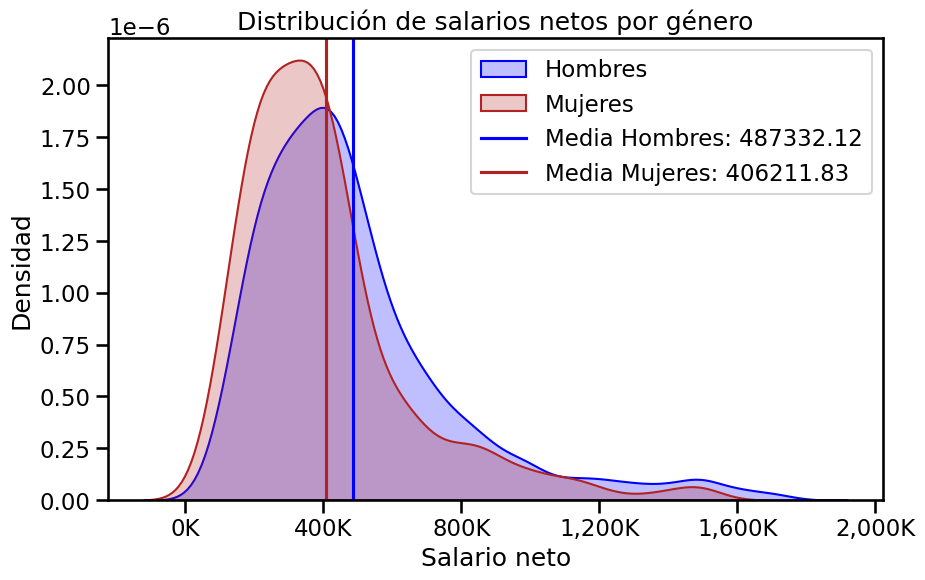

In [10]:
# GRÁFICO: Vemos las distribuciones de salario para hombres y mujeres, marcando sus medias para notar la diferencia existente en la muestra

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 6))

g = sns.kdeplot(data = salary_man, fill = True, color = 'blue', label = 'Hombres')
g2 = sns.kdeplot(data = salary_woman, fill = True, color = 'firebrick', label = 'Mujeres')

ax.axvline(x = salary_man.mean(), color = 'blue', label = f"Media Hombres: {salary_man_estimators['mean'].round(2)}")
ax.axvline(x = salary_woman.mean(), color = 'firebrick', label = f"Media Mujeres: {salary_woman_estimators['mean'].round(2)}")

k_formatter(g = g2, max_value = df2['salary_monthly_NETO'].max(), tick_diff = 400_000)

ax.set_title('Distribución de salarios netos por género')
ax.set_xlabel('Salario neto')
ax.set_ylabel('Densidad')

plt.legend()
plt.show()

Como vemos, tiene una forma similar a la de una distribución normal, pero no es exactamente igual dado que pesa mucho la cola derecha para ambas.

Sin embargo, para poder hacer el correspondiente chequeo y saber cómo seguir, vamos a realizar un test de hipótesis de normalidad que nos indicará si verdaderamente podemos asumir o no que las subpoblaciones tienen distribución normal. Para ello, hay dos pruebas posibles para usar:
- [Prueba de Shapiro-Wilk](https://es.wikipedia.org/wiki/Prueba_de_Shapiro-Wilk)
- [Prueba de Kolmogorov-Smirnov](https://es.wikipedia.org/wiki/Prueba_de_Kolmogorov-Smirnov)

Para este caso, vamos a usar la prueba de Kolmogorov-Smirnov, ya que es más robusta para muestras grandes ($>50$) como es nuestro caso. Suponemos lo siguiente:
- $H_{0M}$: El salario neto mensual de los hombres sigue una distribución normal
- $H_{0W}$: El salario neto mensual de las mujeres sigue una distribución normal

Siendo, entonces, $H_{1M}$ y $H_{1W}$ las hipótesis alternativas correspondientes a no seguir una distribución normal en cada caso.

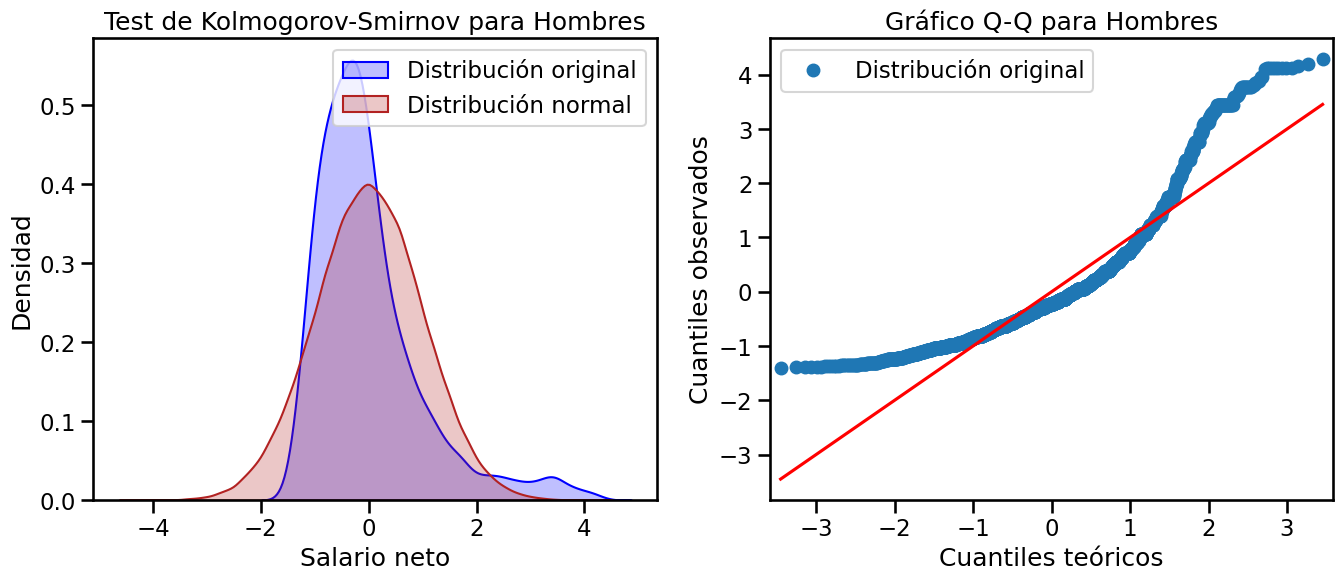

Rechazamos la hipótesis nula con un p-valor de 2.819722754548478e-61


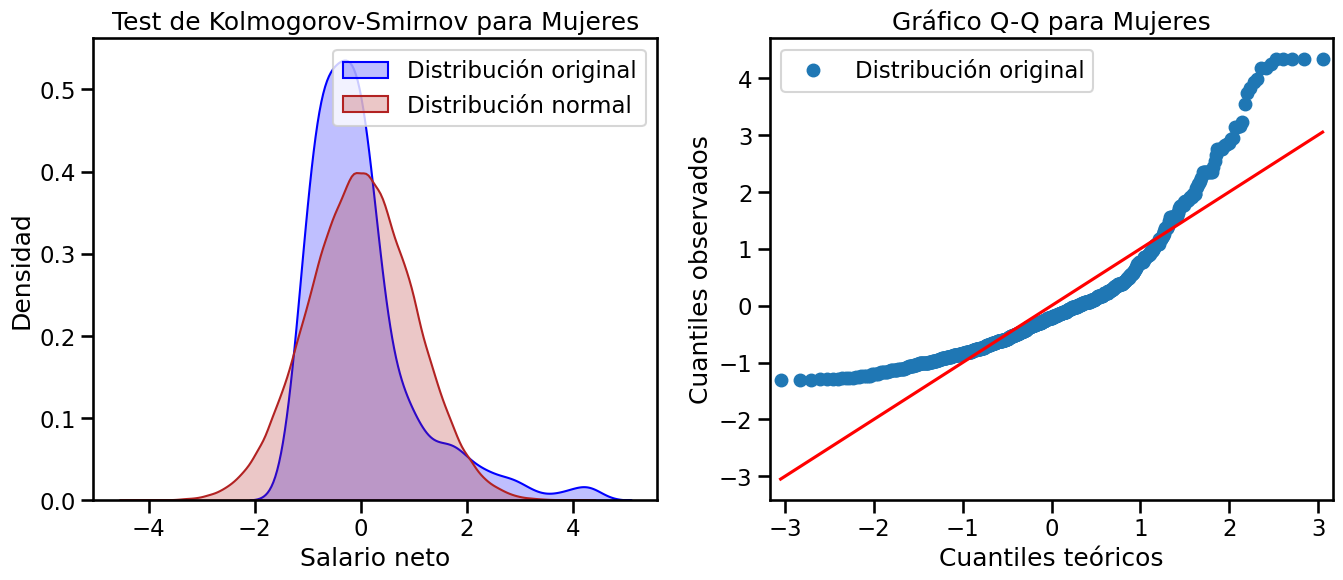

Rechazamos la hipótesis nula con un p-valor de 1.1148713692350098e-17


True

In [11]:
# Verificación de normalidad de los datos con Kolmogorov-Smirnov
def graphical_normality_test(name, distribution, normal):
    """
    Grafica las dos distribuciones a comparar para el test de normalidad
    """
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))

    # Gráfico de densidad
    sns.kdeplot(data = distribution, ax = ax[0], fill = True, color = 'blue', label = 'Distribución original')
    sns.kdeplot(data = normal, ax = ax[0], fill = True, color = 'firebrick', label = 'Distribución normal')

    ax[0].set_title(f'Test de Kolmogorov-Smirnov para {name}')
    ax[0].set_xlabel('Salario neto')
    ax[0].set_ylabel('Densidad')
    ax[0].legend()

    # Gráfico de Q-Q
    sma.qqplot(distribution, line ='s', ax = ax[1], label = 'Distribución original')

    ax[1].set_title(f'Gráfico Q-Q para {name}')
    ax[1].set_xlabel('Cuantiles teóricos')
    ax[1].set_ylabel('Cuantiles observados')
    ax[1].legend()

    plt.show()

def normality_test(name, data, alpha):
    """
    Realiza el test de normalidad de Kolmogorov-Smirnov y grafica las dos distribuciones a comparar
    Nota: Re-escala los datos para comparar con una distribución normal
    """
    re_scaled_data = (data - data.mean()) / data.std()
    k_stat, p_value = st.kstest(re_scaled_data, 'norm')

    graphical_normality_test(name = name, distribution = re_scaled_data, normal = np.random.normal(size = 200_000))

    return hypothesis_test(p_value = p_value, alpha = alpha)

# Test de normalidad
normality_test(name = 'Hombres', data = salary_man, alpha = ALPHA)
normality_test(name = 'Mujeres', data = salary_woman, alpha = ALPHA)

Dado esto, entonces, vemos que no podemos asumir que las subpoblaciones tienen distribución normal. Por ello, para ver si las varianzas son o no distintas, tendremos que usar un método *no paramétrico* de testeo de esta hipótesis.

En este caso, vamos a usar la [Prueba de Levene](https://es.wikipedia.org/wiki/Prueba_de_Levene) para ver si las varianzas son iguales o no. Por ello, consideramos:
- $H_0$: Las varianzas de los salarios netos del grupo de hombres y del grupo de mujeres son iguales
- $H_1$: Las varianzas de los salarios netos del grupo de hombres y del grupo de mujeres son distintas

In [12]:
# Verificación de homocedasticidad (igualdad de varianzas) con el test de Levene
def homocedasticity_test(data1, data2, alpha):
    """
    Realiza el test de homocedasticidad de Levene
    """
    stat, p_value = st.levene(data1, data2)

    return hypothesis_test(p_value = p_value, alpha = alpha)

# Test de homocedasticidad
homocedasticity_test(data1 = salary_man, data2 = salary_woman, alpha = ALPHA)

Rechazamos la hipótesis nula con un p-valor de 0.0001301658597102322


True

Luego, entonces, llegamos a que seguramente *las varianzas no son iguales* entre estas dos subpoblaciones.

Por ello mismo, entonces, ahora como las varianzas no son iguales y por el [TCL](https://en.wikipedia.org/wiki/Central_limit_theorem) (Teorema Central del Límite) las medias muestrales se distribuyen normalmente, podemos usar un [test de Welch](https://en.wikipedia.org/wiki/Welch%27s_t-test) para ver si las medias de los salarios netos de hombres y mujeres son iguales o no, y así poder calcular el intervalo de confianza correspondiente a su diferencia.

*Nota: En particular se puede aplicar el test de Welch directamente como se suele hacer cuando se cumple con el TCL, porque funciona para ambos casos, tanto si las varianzas son iguales como cuando son diferentes. Sin embargo, a fines de realizar un análisis más detallado y utilizar las herramientas que tenemos disponibles, preferimos hacer el análisis previo del test de hipótesis para afirmar o rechazar con seguridad si las varianzas son iguales o no*.

Dado esto, queremos estimar $\hat{\mu_D}$ (donde $\mu_D = \mu_M - \mu_W$) empleando el Método de Welch, el cual usa una T de Student con $v$ grados de libertad, donde $v$ se calcula como:

$$v = \frac{\left(\frac{s_M^2}{n_M} + \frac{s_W^2}{n_W}\right)^2}{\frac{\left(\frac{s_M^2}{n_M}\right)^2}{n_M-1} + \frac{\left(\frac{s_W^2}{n_W}\right)^2}{n_W-1}}$$

y donde el estadístico $t$ es:

$$t = \frac{\bar{X}_M - \bar{X}_W}{\sqrt{\frac{s_M^2}{n_M} + \frac{s_W^2}{n_W}}}$$

por lo que el intervalo de confianza es:

$$\left(\bar{X}_M - \bar{X}_W - t_{\alpha/2, v} \sqrt{\frac{s_M^2}{n_M} + \frac{s_W^2}{n_W}}, \bar{X}_M - \bar{X}_W + t_{\alpha/2, v} \sqrt{\frac{s_M^2}{n_M} + \frac{s_W^2}{n_W}}\right)$$

Luego, si lo calculamos y lo graficamos, tenemos que lo siguiente:


El intervalo de confianza para la diferencia entre las medias de las dos subpoblaciones es de (61782.99, 100457.60)


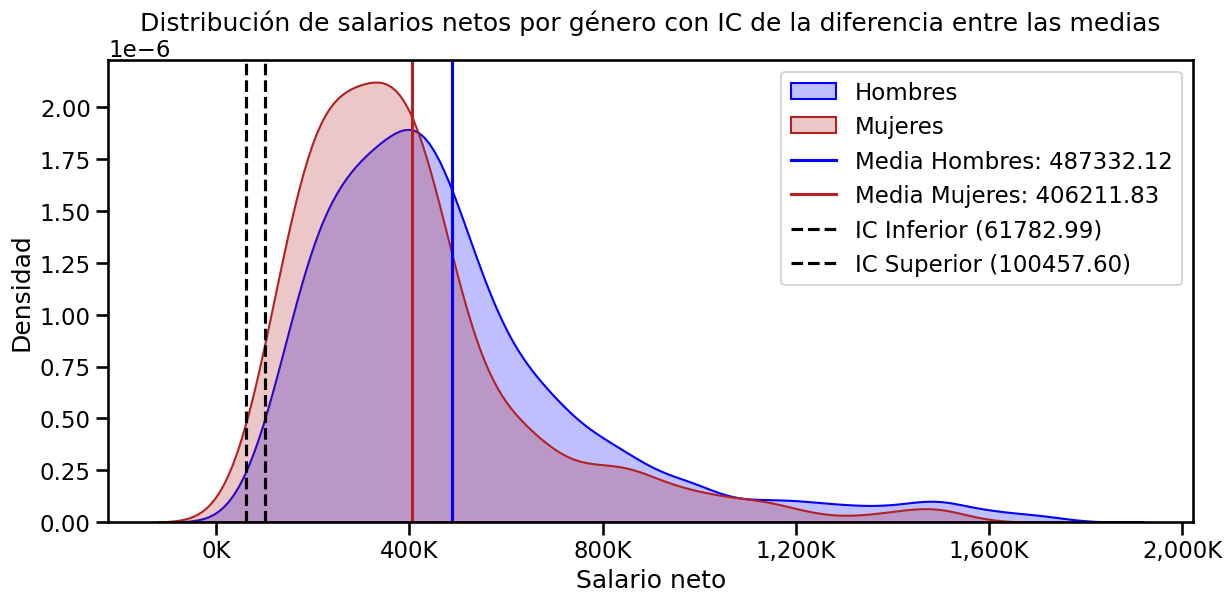

In [13]:
# Test de Welch para calcular el intervalo de confianza de la diferencia entre las medias
def welch_freedom_degree(std1, std2, n1, n2):
    """
    Calcula los grados de libertad para el test de Welch
    """
    num = (std1**2 / n1 + std2**2 / n2)**2
    den = (std1**2 / n1)**2 / (n1 - 1) + (std2**2 / n2)**2 / (n2 - 1)

    return num / den

def welch_confidence_interval(estimators1, estimators2, alpha):
    """
    Calcula el intervalo de confianza de la diferencia entre las medias
    """
    mean1, std1, n1 = estimators1['mean'], estimators1['std'], estimators1['size']
    mean2, std2, n2 = estimators2['mean'], estimators2['std'], estimators2['size']

    freedom_degree = welch_freedom_degree(std1 = std1, std2 = std2, n1 = n1, n2 = n2)

    t = st.t.ppf(q = 1 - alpha / 2, df = freedom_degree)

    lower_bound = (mean1 - mean2) - t * np.sqrt(std1**2 / n1 + std2**2 / n2)
    upper_bound = (mean1 - mean2) + t * np.sqrt(std1**2 / n1 + std2**2 / n2)

    return lower_bound, upper_bound

def graphical_welch_confidence_interval(name1, name2, data1, data2, interval, alpha):
    """
    Grafica el intervalo de confianza de la diferencia entre las medias
    """
    # Gráfico de densidad de las dos distribuciones
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (14, 6))

    g = sns.kdeplot(data = data1, fill = True, color = 'blue', label = name1)
    g2 = sns.kdeplot(data = data2, fill = True, color = 'firebrick', label = name2)

    ax.axvline(x = data1.mean(), color = 'blue', label = f"Media {name1}: {data1.mean().round(2)}")
    ax.axvline(x = data2.mean(), color = 'firebrick', label = f"Media {name2}: {data2.mean().round(2)}")

    k_formatter(g = g2, max_value = max(data1.max(), data2.max()), tick_diff = 400_000)

    ax.set_title('Distribución de salarios netos por género con IC de la diferencia entre las medias')
    ax.set_xlabel('Salario neto')
    ax.set_ylabel('Densidad')

    # Intervalo de confianza
    ax.axvline(x = interval[0], color = 'black', linestyle = '--', label = f'IC Inferior ({interval[0]:.2f})')
    ax.axvline(x = interval[1], color = 'black', linestyle = '--', label = f'IC Superior ({interval[1]:.2f})')

    plt.legend()
    plt.show()

# Calculamos el intervalo de confianza
lower_bound, upper_bound = welch_confidence_interval(estimators1 = salary_man_estimators, \
                                                   estimators2 = salary_woman_estimators, alpha = ALPHA)

print(f"\nEl intervalo de confianza para la diferencia entre las medias de las dos subpoblaciones es de \
({lower_bound:.2f}, {upper_bound:.2f})")

# Graficamos el intervalo de confianza
graphical_welch_confidence_interval(name1 = 'Hombres', name2 = 'Mujeres', data1 = salary_man, \
                                    data2 = salary_woman, interval = (lower_bound, upper_bound), alpha = ALPHA)

Luego, dado esto, ya hemos calculado el intervalo de confianza correspondiente a la diferencia de las medias de los salarios netos de hombres y mujeres.

##### Conclusiones

Este intervalo de confianza se relaciona con el *test de hipótesis* correspondiente dado que ambos son métodos inferenciales que se basan en una distribución muestral aproximada. Los IC utilizan datos de una muestra para estimar un parámetro poblacional, mientras que los tests de hipótesis los usan para probar una hipótesis específica.

De hecho, en general, para cada prueba de hipótesis existe una afirmación equivalente sobre si el valor del parámetro hipotético está incluido en un cierto intervalo de confianza. Es decir, la $H_0$ se rechaza si y solo si el valor hipotético no está incluido en el IC de nivel $1-\alpha$ (considerando que el test tiene el mismo $\alpha$).

### Ejercicio 2: Test de hipótesis


#### 2.1 Formalización

##### Consigna

Describir formalmente los distintos componentes de un test de hipótesis para comprobar si la distribución de los salarios es distinta entre los dos grupos de género.

**Hipótesis Nula**

$H_0=...$

**Estadístico (Pivote)**
  * Identificar el estadístico
  * Escribir qué distribución tiene bajo $H_0$

##### Resolución

En este caso, queremos describir formalmente cada aspecto de nuestro test de hipótesis para ver si la distribución de los salarios es, o no, distinta entre los dos grupos de género.

Para ello, vamos a considerar las siguientes **hipótesis**:
- $H_0$: La media del salario mensual neto del grupo de hombres es **igual** a la media del salario mensual neto del grupo de mujeres
- $H_1$: La media del salario mensual neto del grupo de hombres es **distinta** a la media del salario mensual neto del grupo de mujeres

Asimismo, vamos a considerar un **nivel de significancia** de $\alpha = 0.05$ para nuestro test, para reducir el margen de error de tipo I (rechazar cuando es verdad) que estamos dispuestos a aceptar.

Teniendo esto, y en base a las características vistas en el punto anterior en el cálculo del Intervalo de Confianza, vamos a usar el **test de Welch** para ver si las medias de los salarios netos de hombres y mujeres son iguales o no. Por ello, tenemos que el **estadístico de prueba** es:

$$t = \frac{\bar{X}_M - \bar{X}_W}{\sqrt{\frac{s_M^2}{n_M} + \frac{s_W^2}{n_W}}}$$

Y el grado de libertad $v$ es:

$$v = \frac{\left(\frac{s_M^2}{n_M} + \frac{s_W^2}{n_W}\right)^2}{\frac{\left(\frac{s_M^2}{n_M}\right)^2}{n_M-1} + \frac{\left(\frac{s_W^2}{n_W}\right)^2}{n_W-1}}$$

Dado esto, entonces, gracias a este test obtendremos un **p-valor**, el cual nos permitirá decidir si rechazamos o no la hipótesis nula bajo el nivel de significancia dado. Se rechaza $H_0$ si el p-valor es menor a $\alpha$.

#### 2.2 P-valor

##### Consigna

1. Calcule el p-valor y decida si rechazar o no la hipótesis nula.
2. Interprete el resultado.

Links útiles:
* [Test de hipótesis usando scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)
* [Test de Welch](http://daniellakens.blogspot.com/2015/01/always-use-welchs-t-test-instead-of.html)

##### Resolución

Para resolver este test de hipótesis, hacemos lo siguiente:

In [14]:
# Verificación de igualdad de medias por el Test de Welch
def welch_test(data1, data2, alpha):
    """
    Realiza el test de Welch para evaluar si rechazamos la hipótesis nula
    """
    t_stat, p_value = st.ttest_ind(data1, data2, equal_var = False)

    return hypothesis_test(p_value = p_value, alpha = alpha)

# Test de Welch
welch_test(data1 = salary_man, data2 = salary_woman, alpha = ALPHA)

Rechazamos la hipótesis nula con un p-valor de 4.0736069051658206e-16


True

Por lo que podemos concluir que, en base a nuestra muestra analizada, podemos *rechazar* con bastante seguridad nuestra hipótesis nula, y afirmar, con la misma seguridad, que la media de los salarios netos de los hombres es distinta a la de las mujeres a *nivel poblacional*.

#### 2.3 Potencia del test [Opcional]

##### Consigna

Nuestra muestra, ¿era lo suficientemente grande para detectar si existe o no una diferencia entre los grupos?

1. Utilice la función `tt_ind_solve_power` para calcular el tamaño necesario de la muestra para un poder estadístico de 0.8, 0.9 y 0.95, asumiendo una significancia estadística de 0.05.
2. ¿Cómo intepretan el poder estadístico de un test? Dado su conocimiento de dominio sobre los datos, ¿les parece que esta muestra es lo suficientemente grande para ser representativo de la tendencia general? ¿y para utilizarlo en un juicio penal contra una empresa XX por una causa de discriminación?

[Documentación](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.tt_ind_solve_power.html)

**NOTA: este análisis debería hacerse ANTES de recolectar los datos.**

##### Resolución

Para nuestra resolución, primero calculemos el tamaño necesario que tienen que tener nuestras muestras para los diferentes poderes estadísticos dados (y el nivel de significancia empleado durante todo el notebook de $\alpha = 0.05$).

In [15]:
# Función de cálculo del tamaño necesario para tener un determinado poder estadístico
def calculate_expected_size_for_power(data1, data2, alpha, power):
    """
    Calcula el tamaño necesario para tener un determinado poder estadístico
    """
    effect_size = (data1.mean() - data2.mean()) / data2.std()
    ratio = len(data2) / len(data1)
    
    expected_size1 = sm.stats.power.tt_ind_solve_power(effect_size = effect_size, alpha = alpha, power = power, ratio = ratio)
    expected_size2 = expected_size1 * ratio
    return expected_size1, expected_size2

# Potencia de los tests
statistical_power = [0.8, 0.9, 0.95]
for power in statistical_power:
    expected_size = calculate_expected_size_for_power(data1 = salary_man, data2 = salary_woman, alpha = ALPHA, power = power)
    
    proportion = salary_man_estimators['size'] / expected_size[0]
    assert proportion == salary_woman_estimators['size'] / expected_size[1]

    print(f"\nPara un poder estadístico de {power}, tenemos {proportion:.2f} veces la cantidad de datos necesaria")
    print(f"    Hombres: Necesitamos {expected_size[0]:.0f} datos y tenemos {salary_man_estimators['size']}")
    print(f"    Mujeres: Necesitamos {expected_size[1]:.0f} datos y tenemos {salary_woman_estimators['size']}")


Para un poder estadístico de 0.8, tenemos 9.19 veces la cantidad de datos necesaria
    Hombres: Necesitamos 393 datos y tenemos 3614
    Mujeres: Necesitamos 95 datos y tenemos 871

Para un poder estadístico de 0.9, tenemos 6.87 veces la cantidad de datos necesaria
    Hombres: Necesitamos 526 datos y tenemos 3614
    Mujeres: Necesitamos 127 datos y tenemos 871

Para un poder estadístico de 0.95, tenemos 5.56 veces la cantidad de datos necesaria
    Hombres: Necesitamos 650 datos y tenemos 3614
    Mujeres: Necesitamos 157 datos y tenemos 871


Luego, para poder analizar correctamente estos datos, primero veamos qué es el poder estadístico de un test.
Básicamente, la *potencia de una prueba estadística* es la probabilidad de que la hipótesis alternativa sea aceptada cuando esta es verdadera (es decir, la probabilidad de no cometer un error del tipo II). Por ello, entonces, se considera poder estadístico a la probabilidad de rechazar la hipótesis nula cuando la hipótesis nula es falsa.

Por ello mismo, podemos considerar que es una medida que nos indica qué tan válido y/o representativo es un test estadístico respecto a la prueba que se realiza y en relación al tamaño de las muestras consideradas. Es un factor muy importante a tener en cuenta si queremos realizar un test de hipótesis que sea representativo de la población en general.

Respecto a la consulta de si *la muestra es lo suficientemente grande para poder ser representativo de la tendencia general*, podemos decir que sí, dado que estas son bastante grandes y siempre superiores a lo necesario para los diferentes poderes estadísticos. Sin embargo, algo a considerar es que la muestra de *hombres* es muchísimo más grande que la de *mujeres*, por lo que los resultados que obtengamos van a ser mucho más representativos para esa subpoblación que para la otra.

Y, por último, respecto a la pregunta sobre *la utilización de estas muestras en un juicio penal por causa de discriminación*, consideramos que, si bien las muestras son representativas para cada subpoblación, dada la naturaleza de los juicios y la necesidad de pruebas robustas y con extrema confiabilidad y/o certeza, sería necesario realizar un estudio mucho más profundo y con un mayor tamaño de muestra para poder afirmar con seguridad que existe discriminación en la empresa XX.

Algo a considerar para estos casos, también, es que las muestras que se toman para estos juicios suelen ser *aleatorias* y *estratificadas*, para poder tener una representación más fiel y uniformemente distribuida de la población en general.

Por ello mismo, en resumen, si bien son muestras representativas, consideramos que sería *primordial* tomar una muestra de forma más seria y con un proceso estricto y bien definido, que garantice un gran tamaño de muestra y una representatividad mucho mayor para poder realizar los análisis de esta y afirmar con seguridad que existe discriminación en la empresa XX.

### Ejercicio 3: Comunicación y visualización

#### Consigna

Seleccionen un resultado que les parezca relevante a partir de alguno de los ejercicios del entregable. Diseñen e implementen una comunicación en base a este mensaje, en un archivo *PDF*.

Elijan las palabras y la visualización más adecuadas para que la comunicación sea entendible, efectiva y se adapte a **UNA** de las siguientes situaciones:

1. Una sección en un artículo de difusión a presentar como parte de una organización sin fines de lucro. *No más de 1 página A4 (o dos si los gráficos son muy grandes).*
   - *Ejemplo*: Alguna de las secciones [Los ecosistemas de emprendimiento de América Latina y el Caribe frente al COVID-19: Impactos, necesidades y recomendaciones](https://publications.iadb.org/es/los-ecosistemas-de-emprendimiento-de-america-latina-y-el-caribe-frente-al-covid-19-impactos-necesidades-y-recomendaciones), por ejemplo la sección *2.2. Reacciones de los emprendedores*.
   - *Ejemplo*: Alguna de las secciones de [The state of gender pay gap in 2021](https://www.payscale.com/data/gender-pay-gap?tk=carousel-ps-rc-job)
   - *Puntos clave*:
     1. Simpleza de los gráficos.
     2. Comunicación en lenguaje simple a personas que no son necesariamente expertos de dominio.
     3. Selección de UNA oración sobre la que se hace énfasis.
     4. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.

2. Una publicación científica o reporte técnico interno. *No más de una página A4*:
   - *Ejemplo*: La sección de resultados de [IZA DP No. 12914: The Impact of a Minimum Wage Change on the Distribution of Wages and Household Income](https://www.iza.org/publications/dp/12914/the-impact-of-a-minimum-wage-change-on-the-distribution-of-wages-and-household-income).
   - *Ejemplo*: Alguna de las secciones de [Temporary reduction in daily global CO2 emissions during the COVID-19 forced confinement](https://www.nature.com/articles/s41558-020-0797-x)
   - *Puntos clave*:
     1. Nivel de detalle técnico requerido. Es necesario justificar la validez del análisis.
     2. La idea presentada puede ser más compleja. Pueden asumir que la audiencia tiene conocimiento técnico y va a analizar las visualizaciones en detalle.
     3. Pueden presentar más en detalle las limitaciones del análisis (significancia estadística, etc.)
     4. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.

3. Un tweet (o post de LinkedIn) para la cuenta de su empresa consultora que hace análisis de datos. El objetivo es promocionar un análisis de datos abiertos que van a incluir en su portfolio:
   - *Ejemplo*: [Comparación vacunas covid](https://twitter.com/infobeautiful/status/1381577746527236098?s=20)
   - *Ejemplo*: [Tweet del BID](https://twitter.com/el_BID/status/1388508583944507396?s=20). Lo valioso de este tweet es que usaron un único número para transmitir un mensaje. Puede ser algo así, o con un gráfico muy simple.
   - *Ejemplo*: [Cambio climático](https://twitter.com/UNFCCC/status/1387732156190011394?s=20) Es un muy buen ejemplo, excepto que el gráfico no se lee nada y hay que entrar a la publicación original.
   - *Ejemplo*: [¿Cuánto están los programadores en las empresas?](https://www.linkedin.com/posts/denis-rothman-0b034043_tech-career-work-activity-6793861923269054464-gS6y) (No verificamos la veracidad o seriedad de la fuente).
   - *Punto clave*: su audiencia no va a mirar la visualización por más de unos segundos, y no tiene conocimiento técnico.
   - Tienen que incluir además una *breve* descripción de cómo obtuvieron los datos que están presentando, que no entraría en el tweet.

#### Resolución

Lo interesante para analizar en Argentina respecto a la brecha salarial según el sexo es la proporción del salario neto de las mujeres respecto al de los hombres, tanto en general como en particular para cada provincia. Consideramos relevante para este aspecto, considerar un intervalo de proporciones dado por las distintas combinaciones de los IC generados con T Student para cada provincia (en caso que tengamos la cantidad de datos necesaria para usar el *TCL*, digamos $>50$)

En particular, sean $(I_M, S_M)$ y $(I_W, S_W)$ los IC generados, consideramos las proporciones $\frac{I_W}{S_M}, \frac{S_W}{I_M}$ para generar el intervalo posible de nuestras proporciones.

Sin embargo, no podemos hacer esto directamente, dado que sabemos que los salarios no se distribuyen de forma *normal* y en la gran mayoría de provincias no existe la cantidad suficiente de respuestas para poder utilizar el *TCL* y asumir que las medias muestrales se distribuyen normalmente para generar el correspondiente IC. Por ello mismo, consideraremos únicamente el siguiente conjunto de provincias (CABA se considera aparte): *CABA*, *Bs. As.*, *Córdoba* y *Santa Fe*.

In [16]:
df_per_gender_and_province = \
    df2.groupby(['work_province', 'gender']).size().unstack().fillna(0).astype(int).sort_values(by = 'Varón', ascending = False)

df_per_gender_and_province

gender,Diversidades,Mujer,Otro,Varón
work_province,,,,
Ciudad Autónoma de Buenos Aires,51,487,191,1702
Provincia de Buenos Aires,14,154,75,776
Córdoba,6,76,29,345
Santa Fe,2,66,22,253
Mendoza,2,25,14,118
Tucumán,0,4,5,48
Entre Ríos,1,5,8,48
Misiones,1,3,3,36
Corrientes,0,3,4,35


Como consecuencia, entonces, vamos a generar los IC para toda Argentina, CABA, la provincia de Bs. As, Córdoba y Santa Fe. Generaremos los IC de las medias con una T Student para cada caso, y para ver la diferencia entre las medias, utilizaremos el método general de Welch (que sirve para igualdad o no de varianzas). Para ello, tomamos en cuenta el siguiente código:

In [17]:
# Generador del intervalo de confianza de la media
def mean_confidence_interval(data, alpha):
    """
    Calcula el intervalo de confianza de la media
    """
    return st.t.interval(confidence = 1 - alpha, df = len(data) - 1, loc = np.mean(data), scale = st.sem(data))

# Generador de la tabla de intervalos de confianza para toda Argentina y por provincia
def confidence_interval_table(data, provinces, alpha):
    """
    Genera la tabla de intervalos de confianza para toda Argentina y por provincia, separados por género
    """
    df_r = pd.DataFrame(index = ['Argentina'] + provinces, columns = ['Varón', 'Mujer', 'Diferencia (IC Welch)'])

    # Intervalo de confianza para toda Argentina
    argentina_interval = \
        data[data['gender'].isin(['Varón', 'Mujer'])].groupby('gender')['salary_monthly_NETO'].apply(mean_confidence_interval, alpha = alpha)
    argentina_interval['Diferencia (IC Welch)'] = \
        welch_confidence_interval( \
            estimators1 = calculate_estimators(data = data[data['gender'] == 'Varón']['salary_monthly_NETO']), \
            estimators2 = calculate_estimators(data = data[data['gender'] == 'Mujer']['salary_monthly_NETO']), \
            alpha = ALPHA
        )
    df_r.loc['Argentina'] = argentina_interval

    # Intervalo de confianza por provincia
    for province in provinces:
        province_data = data[(data['gender'].isin(['Varón', 'Mujer'])) & (data['work_province'] == province)]
        province_interval = province_data.groupby('gender')['salary_monthly_NETO'].apply(mean_confidence_interval, alpha = alpha)
        province_interval['Diferencia (IC Welch)'] = \
            welch_confidence_interval( \
                estimators1 = \
                    calculate_estimators(data = province_data[province_data['gender'] == 'Varón']['salary_monthly_NETO']), \
                estimators2 = \
                    calculate_estimators(data = province_data[province_data['gender'] == 'Mujer']['salary_monthly_NETO']), \
                alpha = ALPHA
            )

        df_r.loc[province] = province_interval

    # Generar el rango de proporciones para cada caso
    df_r['Rango de proporciones (V)'] = \
        df_r.apply(lambda x: f"({x['Varón'][0]/x['Mujer'][1]:.2f}, {x['Varón'][1]/x['Mujer'][0]:.2f})", axis = 1)
    df_r['Rango de proporciones (M)'] = \
        df_r.apply(lambda x: f"({x['Mujer'][0]/x['Varón'][1]:.2f}, {x['Mujer'][1]/x['Varón'][0]:.2f})", axis = 1)

    # Aplicar round2 a todas las tuplas
    df_r = df_r.applymap(lambda x: (round(x[0], 2), round(x[1], 2)) if isinstance(x, tuple) else x)

    return df_r

# Calculamos solo para Argentina, CABA, Buenos Aires, Córdoba y Santa Fe
provinces = ['Ciudad Autónoma de Buenos Aires', 'Provincia de Buenos Aires', 'Córdoba', 'Santa Fe']
ci_table = confidence_interval_table(data = df2, provinces = provinces , alpha = ALPHA)
ci_table

C:\Users\emanu\AppData\Local\Temp\ipykernel_10292\1684677191.py:48: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_r = df_r.applymap(lambda x: (round(x[0], 2), round(x[1], 2)) if isinstance(x, tuple) else x)


,Varón,Mujer,Diferencia (IC Welch),Rango de proporciones (V),Rango de proporciones (M)
Argentina,"(477737.09, 496927.16)","(389415.79, 423007.86)","(61782.99, 100457.6)","(1.13, 1.28)","(0.78, 0.89)"
Ciudad Autónoma de Buenos Aires,"(495032.69, 522346.26)","(404404.72, 448099.46)","(56689.51, 108185.26)","(1.10, 1.29)","(0.77, 0.91)"
Provincia de Buenos Aires,"(465562.33, 509222.61)","(349516.0, 445472.46)","(37259.46, 142537.01)","(1.05, 1.46)","(0.69, 0.96)"
Córdoba,"(447242.46, 510930.81)","(335288.77, 457956.97)","(13591.25, 151336.28)","(0.98, 1.52)","(0.66, 1.02)"
Santa Fe,"(449919.82, 520906.55)","(315848.94, 420698.61)","(54159.15, 180119.67)","(1.07, 1.65)","(0.61, 0.94)"


Gracias al cual podemos notar la siguiente información relevante **sobre el 2023**:
- En general, para toda Argentina, una mujer cobraba entre el $78\%$ y el $89\%$ de lo que cobraba un hombre.
- En particular, la desigualdad vista para cada uno de los puntos geográficos considerados es la siguiente:
  - CABA: $77\%$ - $91\%$
  - Bs. As.: $69\%$ - $96\%$
  - Córdoba: $66\%$ - $102\%$
  - Santa Fe: $61\%$ - $94\%$

La misma información pero desde el punto de vista del sueldo neto promedio del hombre es:
- En general, para toda Argentina, un hombre cobraba entre el $113\%$ y el $128\%$ de lo que cobraba una mujer.
- En particular, la desigualdad vista para cada uno de los puntos geográficos considerados es la siguiente:
  - CABA: $110\%$ - $129\%$
  - Bs. As.: $105\%$ - $146\%$
  - Córdoba: $98\%$ - $152\%$
  - Santa Fe: $107\%$ - $165\%$

Lo anterior es respecto a lo relativo. Ahora, si nos fijamos en las diferencias absolutas, tenemos que:
- En general, para toda Argentina, una mujer cobraba entre $\$61.782$ y $\$100.457$ menos que un hombre.
- En particular, la desigualdad vista para cada uno de los puntos geográficos considerados es la siguiente:
  - CABA: Las mujeres cobraban entre $\$56.689$ y $\$108.185$ menos que los hombres
  - Bs. As.: Las mujeres cobraban entre $\$37.259$ y $\$142.537$ menos que los hombres
  - Córdoba: Las mujeres cobraban entre $\$13.591$ y $\$151.336$ menos que los hombres
  - Santa Fe: Las mujeres cobraban entre $\$54.159$ y $\$180.119$ menos que los hombres

*Estos datos se vuelven sumamente interesantes cuando recordamos que el sueldo neto correspondiente al Salario Mínimo Vital y Móvil a mediados del 2023 era del $\$87.987$*

*Nota*: los enlaces de lo anterior son [SMVyM](https://www.argentina.gob.ar/noticias/incremento-del-salario-minimo-vital-y-movil) y [aportes](https://www.argentina.gob.ar/trabajo/buscastrabajo/conocetusderechos/salario#aportes).

Luego, en base a estos datos, decidimos quedarnos con el hecho de que, en promedio, una mujer en el ámbito de la programación:
- Cobra entre el $11\%$ y $22\%$ menos que un hombre
- Cobra entre $\$61.782$ y $\$100.457$ menos que un hombre, lo que es casi equivalente a un *Salario Mínimo Vital y Móvil* (ya que se corresponde a $73.029,21$)

Con esta información, decidimos el post de LinkedIn (se encuentra [aquí](https://drive.google.com/file/d/1kbSUi2MlXitvNUY85iylJZsD6S1HkaM_/view?usp=sharing) en PDF), el cual tiene la siguiente imagen:

<img src = "https://raw.githubusercontent.com/helcsnewsxd/DiploDatosFAMAF-2024-Analisis-y-visualizacion-de-datos/main/evaluaci%C3%B3n/entregable2/personal_imagen_post_linkedin.png">